# <font size="5">Import

In [1]:
import os
import os.path
import sys
from sys import platform
from shutil import copyfile
import socket
import psutil
import GPUtil
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from scipy.ndimage import gaussian_filter,rotate
from tifffile import imread, TiffFile, imsave
from PIL import Image
import copy
import cv2
import warnings
import timeit
import pickle
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ["Arial"]
plt.rcParams['pdf.fonttype'] = 42
def imshow_cleanup(ax):
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_facecolor('none')
    return ax

In [2]:
filePath = ""
fileName = "5khz-ms-round2_00037_00010.tif"
refImgFile = "M_2out-blk_nor.png"

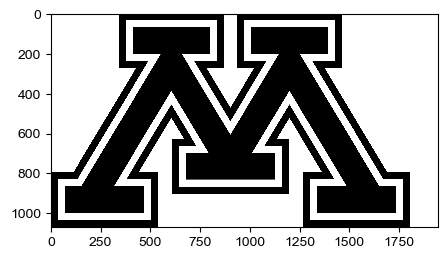

In [3]:
refImg = Image.open(os.path.join(filePath,refImgFile))
plt.figure(figsize = (5,5))
plt.imshow(refImg,interpolation='none')

In [4]:
tiff = TiffFile(os.path.join(filePath,fileName))
width = tiff.pages[0].imagewidth
height = tiff.pages[0].imagelength
dtype = tiff.pages[0].dtype
nframes = int(len(tiff.pages))
data=imread(os.path.join(filePath,fileName))
data_meanProj = np.nanmean(data,axis=0)

<tifffile.TiffFile '5khz-ms-round2_00037_00010.tif'> asarray failed to reshape (1000, 190, 72) to (50000, 190, 72)


# <font size="5">Bidir EOD Correction

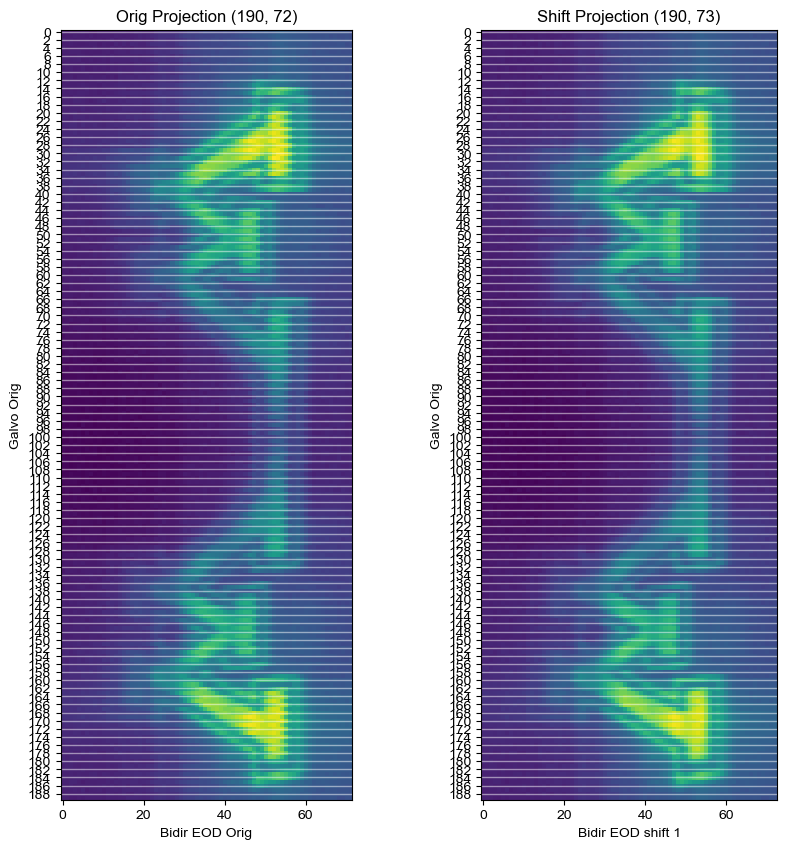

In [5]:
EOD_axis_px_shift = 1 #Operates on ODD indices
data_EOD_Shifted = np.ones((data.shape[0],data.shape[1],data.shape[2]+np.absolute(EOD_axis_px_shift)),dtype='float32')*np.nan
for y in range(data.shape[1]):
    if EOD_axis_px_shift > 0:
        if np.mod(y,2) == 0:
            data_EOD_Shifted[:,y,0:data.shape[2]] = data[:,y,0:data.shape[2]]
            for x in range(data.shape[2],data.shape[2]+np.absolute(EOD_axis_px_shift)):
                data_EOD_Shifted[:,y,x] = data[:,y,data.shape[2]-1]
        else:
            data_EOD_Shifted[:,y,np.absolute(EOD_axis_px_shift):data.shape[2]+np.absolute(EOD_axis_px_shift)] = data[:,y,0:data.shape[2]]
            for x in range(0,np.absolute(EOD_axis_px_shift)):
                data_EOD_Shifted[:,y,x] = data[:,y,0]
    elif EOD_axis_px_shift < 0:
        if np.mod(y,2) == 0:
            data_EOD_Shifted[:,y,np.absolute(EOD_axis_px_shift):data.shape[2]+np.absolute(EOD_axis_px_shift)] = data[:,y,0:data.shape[2]]
        else:
            data_EOD_Shifted[:,y,0:data.shape[2]] = data[:,y,0:data.shape[2]]
    else:
        data_EOD_Shifted[:,y,0:data.shape[2]] = data[:,y,0:data.shape[2]]
data_EOD_Shifted_meanProj = np.nanmean(data_EOD_Shifted,axis=0)
fig,ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(data_meanProj,interpolation='none')
ax[0].set_ylabel("Galvo Orig")
ax[0].set_xlabel("Bidir EOD Orig")
ax[0].set_title("Orig Projection "+str(data_meanProj.shape))
ax[0].set_yticks(np.arange(0, data_meanProj.shape[0], 2))
ax[0].grid(color ='w', linestyle='-', linewidth=1,alpha=0.5,axis = 'y')
ax[1].imshow(data_EOD_Shifted_meanProj,interpolation='none')
ax[1].set_ylabel("Galvo Orig")
ax[1].set_xlabel("Bidir EOD shift "+str(EOD_axis_px_shift))
ax[1].set_title("Shift Projection "+str(data_EOD_Shifted_meanProj.shape))
ax[1].set_yticks(np.arange(0, data_EOD_Shifted_meanProj.shape[0], 2))
ax[1].grid(color ='w', linestyle='-', linewidth=1,alpha=0.5,axis = 'y')


# <font size="5">Bidir EOD Padding

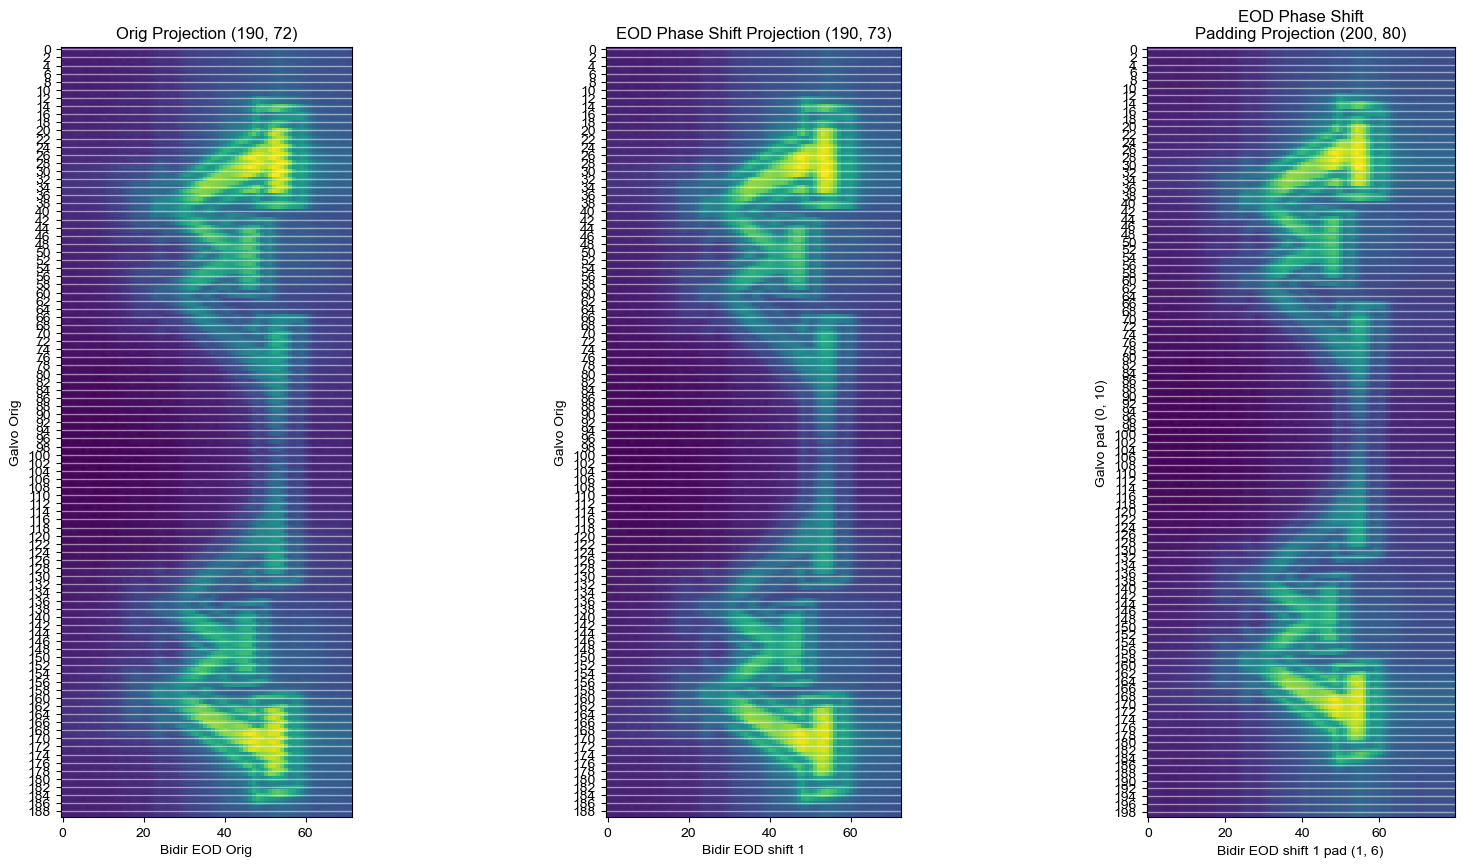

In [6]:
EOD_padding = (1,6)
galvo_padding = (0,10)
data_EOD_Shifted_pad = np.pad(data_EOD_Shifted, ((0,0), (0, 0), EOD_padding), 'edge')
data_EOD_Shifted_pad = np.pad(data_EOD_Shifted_pad, ((0,0), galvo_padding, (0, 0)), 'edge')
data_EOD_Shifted_pad_meanProj = np.nanmean(data_EOD_Shifted_pad,axis=0)

fig,ax = plt.subplots(1,3,figsize = (20,10))
ax[0].imshow(data_meanProj,interpolation='none')
ax[0].set_ylabel("Galvo Orig")
ax[0].set_xlabel("Bidir EOD Orig")
ax[0].set_title("Orig Projection "+str(data_meanProj.shape))
ax[0].set_yticks(np.arange(0, data_meanProj.shape[0], 2))
ax[0].grid(color ='w', linestyle='-', linewidth=1,alpha=0.5,axis = 'y')
ax[1].imshow(data_EOD_Shifted_meanProj,interpolation='none')
ax[1].set_ylabel("Galvo Orig")
ax[1].set_xlabel("Bidir EOD shift "+str(EOD_axis_px_shift))
ax[1].set_title("EOD Phase Shift Projection "+str(data_EOD_Shifted_meanProj.shape))
ax[1].set_yticks(np.arange(0, data_EOD_Shifted_meanProj.shape[0], 2))
ax[1].grid(color ='w', linestyle='-', linewidth=1,alpha=0.5,axis = 'y')
ax[2].imshow(data_EOD_Shifted_pad_meanProj,interpolation='none')
ax[2].set_ylabel("Galvo pad "+str(galvo_padding))
ax[2].set_xlabel("Bidir EOD shift "+str(EOD_axis_px_shift)+" pad "+str(EOD_padding))
ax[2].set_title("EOD Phase Shift\nPadding Projection "+str(data_EOD_Shifted_pad_meanProj.shape))
ax[2].set_yticks(np.arange(0, data_EOD_Shifted_pad_meanProj.shape[0], 2))
ax[2].grid(color ='w', linestyle='-', linewidth=1,alpha=0.5,axis = 'y')


# <font size="5">No EOD Unfolded Correction

(-1.0, 80.0)

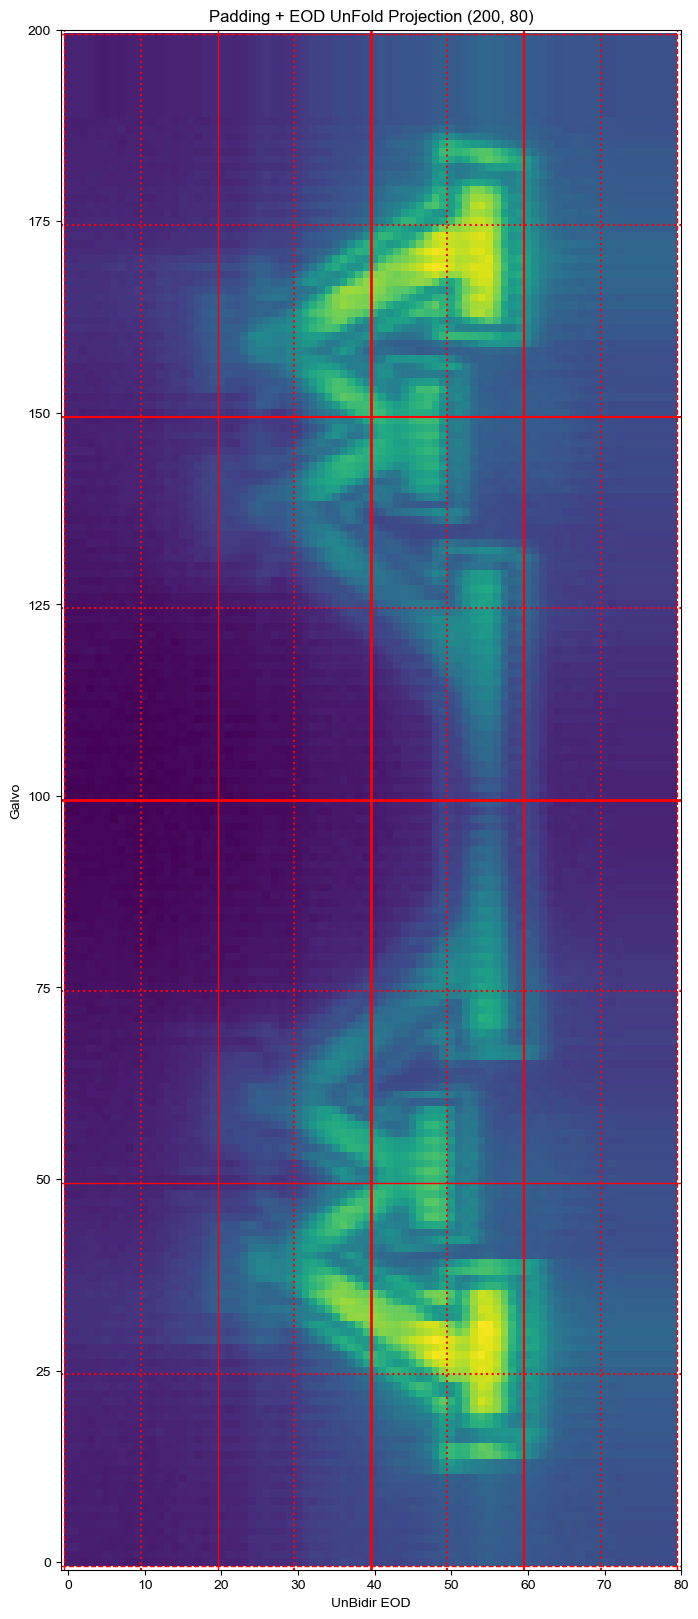

In [7]:
plt.figure(figsize = (20,20))
plt.imshow(data_EOD_Shifted_pad_meanProj,interpolation='none',)
plt.axvline(np.floor(data_EOD_Shifted_pad_meanProj.shape[1]*(0/8))-0.5,lw = 1,linestyle='--',color =(1,0,0))
plt.axvline(np.floor(data_EOD_Shifted_pad_meanProj.shape[1]*(1/8))-0.5,linestyle=':',color =(1,0,0))
plt.axvline(np.floor(data_EOD_Shifted_pad_meanProj.shape[1]*(2/8))-0.5,lw = 1, color =(1,0,0))
plt.axvline(np.floor(data_EOD_Shifted_pad_meanProj.shape[1]*(3/8))-0.5,linestyle=':',color =(1,0,0))
plt.axvline(np.round(data_EOD_Shifted_pad_meanProj.shape[1]*(4/8))-0.5,lw = 2, color =(1,0,0))
plt.axvline(np.ceil(data_EOD_Shifted_pad_meanProj.shape[1]*(5/8))-0.5,linestyle=':',color =(1,0,0))
plt.axvline(np.ceil(data_EOD_Shifted_pad_meanProj.shape[1]*(6/8))-0.5,color =(1,0,0))
plt.axvline(np.ceil(data_EOD_Shifted_pad_meanProj.shape[1]*(7/8))-0.5,linestyle=':',color =(1,0,0))
plt.axvline(np.ceil(data_EOD_Shifted_pad_meanProj.shape[1]*(8/8))-0.5,lw = 1,linestyle='--',color =(1,0,0))
plt.axhline(np.floor(data_EOD_Shifted_pad_meanProj.shape[0]*(0/8))-0.5,lw = 1,linestyle='--',color =(1,0,0))
plt.axhline(np.floor(data_EOD_Shifted_pad_meanProj.shape[0]*(1/8))-0.5,linestyle=':',color =(1,0,0))
plt.axhline(np.floor(data_EOD_Shifted_pad_meanProj.shape[0]*(2/8))-0.5,lw = 1, color =(1,0,0))
plt.axhline(np.floor(data_EOD_Shifted_pad_meanProj.shape[0]*(3/8))-0.5,linestyle=':',color =(1,0,0))
plt.axhline(np.round(data_EOD_Shifted_pad_meanProj.shape[0]*(4/8))-0.5,lw = 2, color =(1,0,0))
plt.axhline(np.ceil(data_EOD_Shifted_pad_meanProj.shape[0]*(5/8))-0.5,linestyle=':',color =(1,0,0))
plt.axhline(np.ceil(data_EOD_Shifted_pad_meanProj.shape[0]*(6/8))-0.5,color =(1,0,0))
plt.axhline(np.ceil(data_EOD_Shifted_pad_meanProj.shape[0]*(7/8))-0.5,linestyle=':',color =(1,0,0))
plt.axhline(np.ceil(data_EOD_Shifted_pad_meanProj.shape[0]*(8/8))-0.5,lw = 1,linestyle='--',color =(1,0,0))
plt.ylabel("Galvo")
plt.xlabel("UnBidir EOD")
plt.title("Padding + EOD UnFold Projection "+str(data_EOD_Shifted_pad_meanProj.shape))
plt.ylim([-1,data_EOD_Shifted_pad_meanProj.shape[0]])
plt.xlim([-1,data_EOD_Shifted_pad_meanProj.shape[1]])

# <font size="5">EOD and Galvo Corrections

In [11]:
EOD_Upscale = 5
Galvo_Upscale = 5
temp = cv2.resize(data_EOD_Shifted_pad_meanProj, (0,0), fx=EOD_Upscale, fy=Galvo_Upscale)
data_EOD_Shifted_pad_Up = np.ones((data_EOD_Shifted_pad.shape[0],temp.shape[0],temp.shape[1]))*np.nan
for t in range(data_EOD_Shifted_pad.shape[0]):
    data_EOD_Shifted_pad_Up[t,:,:] = cv2.resize(data_EOD_Shifted_pad[t,:,:], (0,0), fx=EOD_Upscale, fy=Galvo_Upscale)
data_EOD_Shifted_pad_Up_meanProj = np.nanmean(data_EOD_Shifted_pad_Up,axis=0)


In [12]:
EOD_bidir_turn_px = 400
EOD_distortion_factor = 0.3 * np.array([-1, 1])
EOD_correction_freq = 0.5
EOD_phase_shift = False
EOD_correction_phase_shift_px = 0
EOD_correction_shift_px = 0
EOD_distortion = 'sin' #cos
EOD_interpolation = cv2.INTER_LINEAR

galvo_bidir_turn_px = 500
galvo_distortion_factor = 0.2 * np.array([-1, 1, -1, 1])
galvo_correction_freq = 0.9
galvo_phase_shift = True
galvo_correction_phase_shift_px = -60
galvo_correction_shift_px = 0
galvo_distortion = 'sin' #cos
galvo_interpolation = cv2.INTER_LINEAR

galvo_correction_phase_shift = -0.33929200658769765


(1000.0, 0.0)

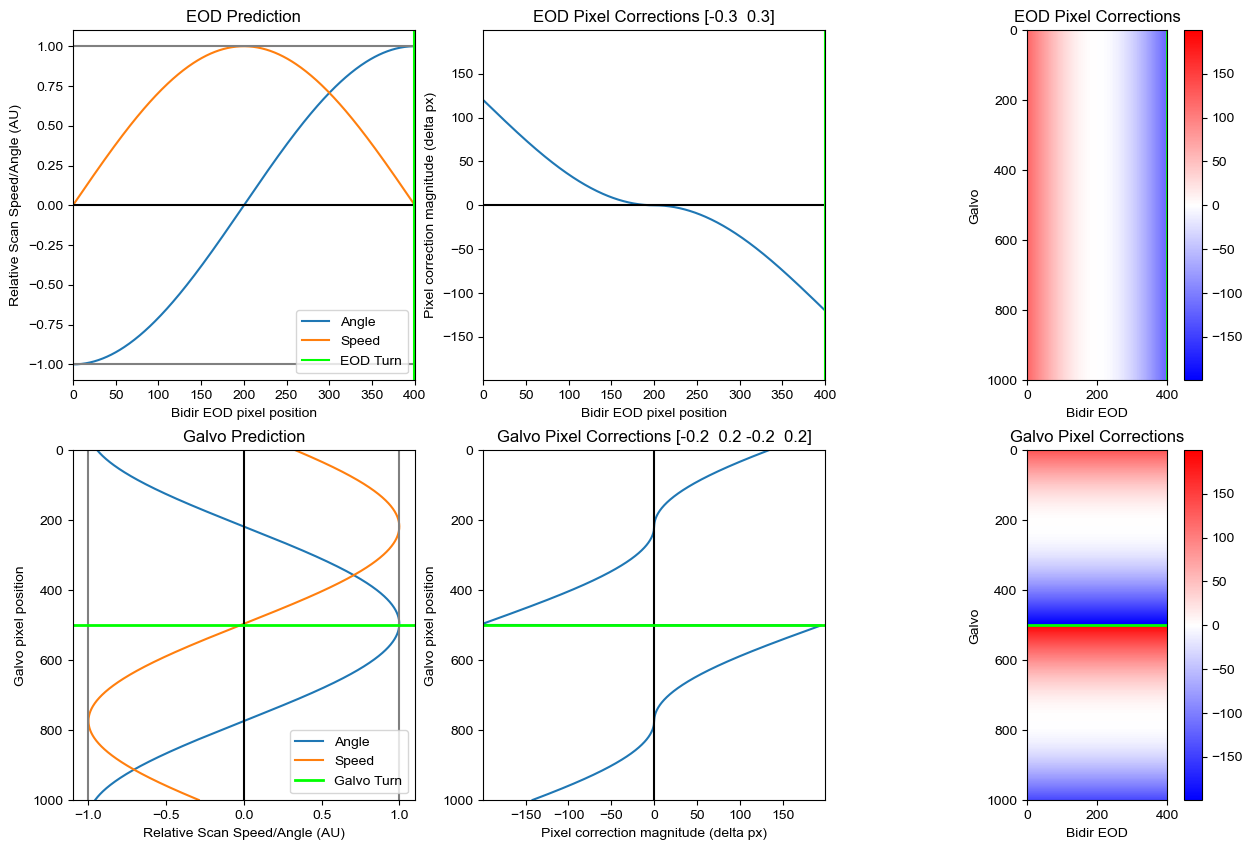

In [13]:
EOD_xdata = np.arange(0,data_EOD_Shifted_pad_Up_meanProj.shape[1])
EOD_rel_xdata = np.arange(0,data_EOD_Shifted_pad_Up_meanProj.shape[1])-EOD_bidir_turn_px
h, w = data_EOD_Shifted_pad_Up_meanProj.shape[:2]
EOD_orig_map_x, EOD_orig_map_y = np.meshgrid(np.arange(w), np.arange(h))
if EOD_phase_shift:
    EOD_correction_phase_shift = (EOD_correction_phase_shift_px/w)* 2 * np.pi * EOD_correction_freq
    print(f'EOD_correction_phase_shift = {EOD_correction_phase_shift}')
else:
    EOD_correction_phase_shift = 0
x1_norm = ((EOD_orig_map_x) / (w)) * 2 * np.pi * EOD_correction_freq
if EOD_distortion == 'sin':
    EOD_distortion_field = np.sin(x1_norm-EOD_correction_phase_shift) * w
    EOD_speed = np.sin(x1_norm[0,:]-EOD_correction_phase_shift)
    EOD_angle = np.cos(x1_norm[0,:]-EOD_correction_phase_shift) * -1
else:
    EOD_distortion_field = np.cos(x1_norm-EOD_correction_phase_shift) * w
    EOD_speed = np.cos(x1_norm[0,:]-EOD_correction_phase_shift)
    EOD_angle = np.sin(x1_norm[0,:]-EOD_correction_phase_shift) * -1
##############################################################
EOD_distortion_field = np.absolute(np.absolute(EOD_distortion_field)-w)
EOD_distortion_field[:,0:np.nanargmax(EOD_speed)] = EOD_distortion_field[:,0:np.nanargmax(EOD_speed)] * EOD_distortion_factor[0]
EOD_distortion_field[:,np.nanargmax(EOD_speed):w] = EOD_distortion_field[:,np.nanargmax(EOD_speed):w] * EOD_distortion_factor[1]
EOD_correction_map = EOD_orig_map_x + EOD_distortion_field
EOD_correction_map_x = EOD_correction_map.astype(np.float32)
EOD_orig_map_y = EOD_orig_map_y.astype(np.float32)
data_EOD_ShiftedCorrected_meanProj = cv2.remap(data_EOD_Shifted_pad_Up_meanProj, EOD_correction_map_x, EOD_orig_map_y, EOD_interpolation)
EOD_distortion_correction = EOD_orig_map_x-EOD_correction_map_x
##############################################################
galvo_ydata = np.arange(0,data_EOD_Shifted_pad_Up_meanProj.shape[0])
galvo_rel_ydata = np.arange(0,data_EOD_Shifted_pad_Up_meanProj.shape[0])-galvo_bidir_turn_px
h, w = data_EOD_Shifted_pad_Up_meanProj.shape[:2]
galvo_orig_map_x, galvo_orig_map_y = np.meshgrid(np.arange(w), np.arange(h))
if galvo_phase_shift:
    galvo_correction_phase_shift = (galvo_correction_phase_shift_px/h)* 2 * np.pi * galvo_correction_freq
    print(f'galvo_correction_phase_shift = {galvo_correction_phase_shift}')
else:
    galvo_correction_phase_shift = 0
y1_norm = ((galvo_orig_map_y) / (h)) * 2 * np.pi * galvo_correction_freq
if galvo_distortion == 'sin':
    galvo_distortion_field = np.sin(y1_norm-galvo_correction_phase_shift) * h
    galvo_speed = np.sin(y1_norm[:,0]-galvo_correction_phase_shift)
    galvo_angle = np.cos(y1_norm[:,0]-galvo_correction_phase_shift) * -1
else:
    galvo_distortion_field = np.cos(y1_norm-galvo_correction_phase_shift) * h
    galvo_speed = np.cos(y1_norm[:,0]-galvo_correction_phase_shift)
    galvo_angle = np.sin(y1_norm[:,0]-galvo_correction_phase_shift) * -1
##############################################################
galvo_distortion_field = np.absolute(np.absolute(galvo_distortion_field)-h)
galvo_distortion_field[0:np.nanargmax(galvo_speed),:] = galvo_distortion_field[0:np.nanargmax(galvo_speed),:] * galvo_distortion_factor[0]
galvo_distortion_field[np.nanargmax(galvo_speed):int(h/2),:] = galvo_distortion_field[np.nanargmax(galvo_speed):int(h/2),:] * galvo_distortion_factor[1]
galvo_distortion_field[int(h/2):np.nanargmin(galvo_speed),:] = galvo_distortion_field[int(h/2):np.nanargmin(galvo_speed),:] * galvo_distortion_factor[2]
galvo_distortion_field[np.nanargmin(galvo_speed):h,:] = galvo_distortion_field[np.nanargmin(galvo_speed):h,:] * galvo_distortion_factor[3]
galvo_correction_map = galvo_orig_map_y + galvo_distortion_field
galvo_correction_map_y = galvo_correction_map.astype(np.float32)
galvo_orig_map_x = galvo_orig_map_x.astype(np.float32)
data_EOD_ShiftedCorrected_meanProj = cv2.remap(data_EOD_Shifted_pad_Up_meanProj, galvo_orig_map_x, galvo_correction_map_y, galvo_interpolation)
galvo_distortion_correction = galvo_orig_map_y-galvo_correction_map_y
max_distortion_correction = np.max([np.max(np.absolute(EOD_distortion_correction)), np.max(np.absolute(galvo_distortion_correction))])
##############################################################
fig,ax = plt.subplots(2,3,figsize = (15,10))
ax[0,0].plot(EOD_xdata,EOD_angle,label='Angle')
ax[0,0].plot(EOD_xdata,EOD_speed,label='Speed')
ax[0,0].axhline(-1,color = (0.5,0.5,0.5))
ax[0,0].axhline(0,color = (0,0,0))
ax[0,0].axhline(1,color = (0.5,0.5,0.5))
ax[0,0].axvline(EOD_bidir_turn_px-0.5,color =(0,1,0),label='EOD Turn')
ax[0,0].legend()
ax[0,0].set_xlim([0,data_EOD_Shifted_pad_Up_meanProj.shape[1]])
ax[0,0].set_title('EOD Prediction')
ax[0,0].set_xlabel('Bidir EOD pixel position')
ax[0,0].set_ylabel('Relative Scan Speed/Angle (AU)')

ax[0,1].plot(EOD_xdata,EOD_distortion_field[0,:]*-1)
ax[0,1].axhline(0,color = (0,0,0))
ax[0,1].axvline(EOD_bidir_turn_px-0.5,color =(0,1,0))
ax[0,1].set_xlim([0,data_EOD_Shifted_pad_Up_meanProj.shape[1]])
ax[0,1].set_ylim([-1*max_distortion_correction,max_distortion_correction])
ax[0,1].set_title('EOD Pixel Corrections '+str(EOD_distortion_factor))
ax[0,1].set_xlabel('Bidir EOD pixel position')
ax[0,1].set_ylabel('Pixel correction magnitude (delta px)')

im = ax[0,2].imshow(EOD_distortion_correction,interpolation='none',cmap='bwr',\
           vmin=-1*max_distortion_correction,vmax=max_distortion_correction)
plt.colorbar(im)
ax[0,2].axvline(EOD_bidir_turn_px-0.5,color =(0,1,0),lw = 2)
ax[0,2].set_title('EOD Pixel Corrections')
ax[0,2].set_xlabel('Bidir EOD')
ax[0,2].set_ylabel('Galvo')
ax[0,2].set_xlim([0,EOD_distortion_correction.shape[1]])
ax[0,2].set_ylim([EOD_distortion_correction.shape[0],0])

ax[1,0].plot(galvo_angle,galvo_ydata,label='Angle')
ax[1,0].plot(galvo_speed,galvo_ydata,label='Speed')
ax[1,0].axvline(-1,color = (0.5,0.5,0.5))
ax[1,0].axvline(0,color = (0,0,0))
ax[1,0].axvline(1,color = (0.5,0.5,0.5))
ax[1,0].axhline(galvo_bidir_turn_px-0.5,color =(0,1,0),lw = 2,label='Galvo Turn')
ax[1,0].legend()
ax[1,0].set_ylim([data_EOD_Shifted_pad_Up_meanProj.shape[0],0])
ax[1,0].set_title('Galvo Prediction')
ax[1,0].set_ylabel('Galvo pixel position')
ax[1,0].set_xlabel('Relative Scan Speed/Angle (AU)')

ax[1,1].plot(galvo_distortion_field[:,0]*-1,galvo_ydata)
ax[1,1].axvline(0,color = (0,0,0))
ax[1,1].axhline(galvo_bidir_turn_px-0.5,color =(0,1,0),lw = 2)
ax[1,1].set_ylim([data_EOD_Shifted_pad_Up_meanProj.shape[0],0])
ax[1,1].set_xlim([-1*max_distortion_correction,max_distortion_correction])
ax[1,1].set_title('Galvo Pixel Corrections '+str(galvo_distortion_factor))
ax[1,1].set_ylabel('Galvo pixel position')
ax[1,1].set_xlabel('Pixel correction magnitude (delta px)')

im = ax[1,2].imshow(galvo_distortion_correction,interpolation='none',cmap='bwr',\
           vmin=-1*max_distortion_correction,vmax=max_distortion_correction)
ax[1,2].invert_yaxis()
plt.colorbar(im)
ax[1,2].axhline(galvo_bidir_turn_px-0.5,color =(0,1,0),lw = 2)
ax[1,2].set_title('Galvo Pixel Corrections')
ax[1,2].set_xlabel('Bidir EOD')
ax[1,2].set_ylabel('Galvo')
ax[1,2].set_xlim([0,galvo_distortion_correction.shape[1]])
ax[1,2].set_ylim([galvo_distortion_correction.shape[0],0])


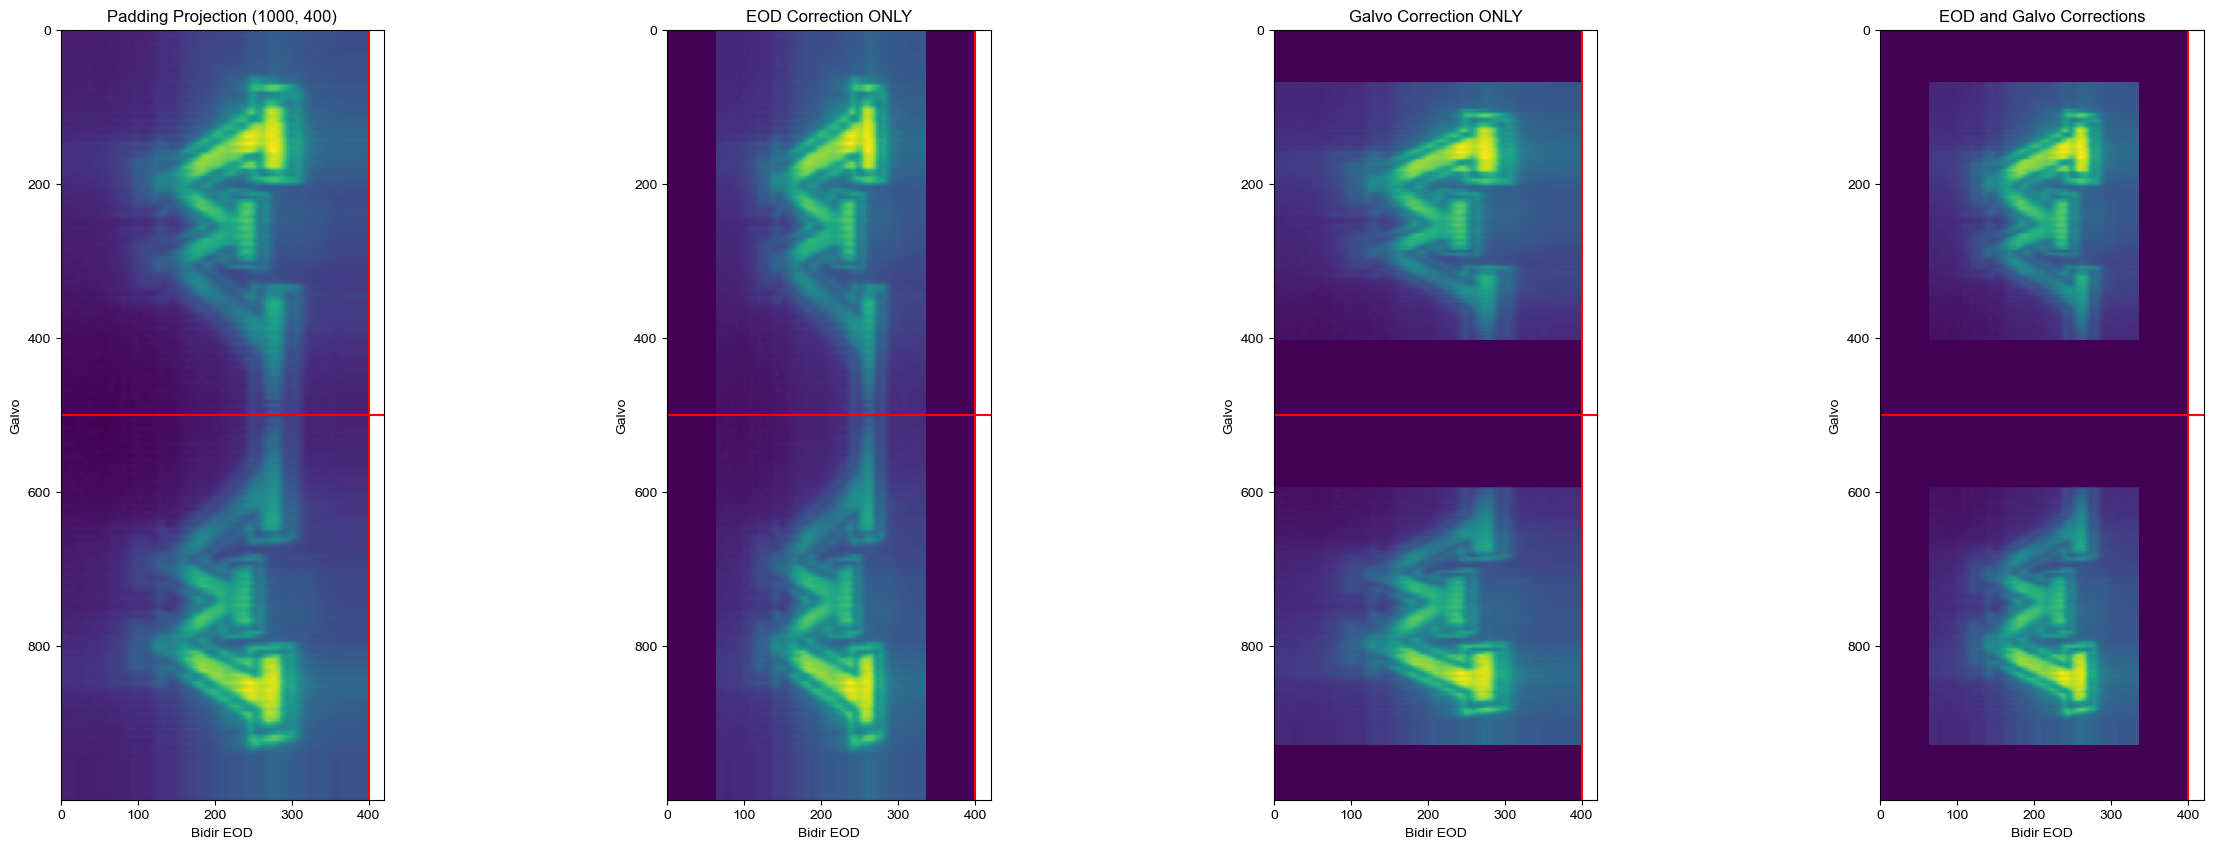

In [14]:
data_EOD_Shifted_pad_Up_EODCorr = np.zeros_like(data_EOD_Shifted_pad_Up)
for t in range(data_EOD_Shifted_pad_Up.shape[0]):
    tempImg = copy.deepcopy(data_EOD_Shifted_pad_Up[t,:,:])
    tempImg = cv2.remap(tempImg, EOD_correction_map_x, EOD_orig_map_y, EOD_interpolation)
    data_EOD_Shifted_pad_Up_EODCorr[t,:,:] = data_EOD_Shifted_pad_Up_EODCorr[t,:,:] + tempImg
data_EOD_Shifted_pad_Up_EODCorr_meanProj = np.nanmean(data_EOD_Shifted_pad_Up_EODCorr,axis=0)
##############################################################
data_EOD_Shifted_pad_Up_GalvoCorr = np.zeros_like(data_EOD_Shifted_pad_Up)
for t in range(data_EOD_Shifted_pad_Up.shape[0]):
    tempImg = copy.deepcopy(data_EOD_Shifted_pad_Up[t,:,:])
    tempImg[galvo_bidir_turn_px:data_EOD_Shifted_pad_Up.shape[1],:] = 0
    tempImg = cv2.remap(tempImg, galvo_orig_map_x, galvo_correction_map_y, galvo_interpolation)
    tempImg[galvo_bidir_turn_px:data_EOD_Shifted_pad_Up.shape[1],:] = 0
    data_EOD_Shifted_pad_Up_GalvoCorr[t,:,:] = data_EOD_Shifted_pad_Up_GalvoCorr[t,:,:] + tempImg
    tempImg = copy.deepcopy(data_EOD_Shifted_pad_Up[t,:,:])
    tempImg[0:galvo_bidir_turn_px,:] = 0
    tempImg = cv2.remap(tempImg, galvo_orig_map_x, galvo_correction_map_y, galvo_interpolation)
    tempImg[0:galvo_bidir_turn_px,:] = 0
    data_EOD_Shifted_pad_Up_GalvoCorr[t,:,:] = data_EOD_Shifted_pad_Up_GalvoCorr[t,:,:] + tempImg
data_EOD_Shifted_pad_Up_GalvoCorr_meanProj = np.nanmean(data_EOD_Shifted_pad_Up_GalvoCorr,axis=0)
##############################################################
data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr = np.zeros_like(data_EOD_Shifted_pad_Up)
for t in range(data_EOD_Shifted_pad_Up.shape[0]):
    tempImg = copy.deepcopy(data_EOD_Shifted_pad_Up_EODCorr[t,:,:])
    tempImg[galvo_bidir_turn_px:data_EOD_Shifted_pad_Up.shape[1],:] = 0
    tempImg = cv2.remap(tempImg, galvo_orig_map_x, galvo_correction_map_y, galvo_interpolation)
    tempImg[galvo_bidir_turn_px:data_EOD_Shifted_pad_Up.shape[1],:] = 0
    data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr[t,:,:] = data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr[t,:,:] + tempImg
    tempImg = copy.deepcopy(data_EOD_Shifted_pad_Up_EODCorr[t,:,:])
    tempImg[0:galvo_bidir_turn_px,:] = 0
    tempImg = cv2.remap(tempImg, galvo_orig_map_x, galvo_correction_map_y, galvo_interpolation)
    tempImg[0:galvo_bidir_turn_px,:] = 0
    data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr[t,:,:] = data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr[t,:,:] + tempImg  
data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj = np.nanmean(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr,axis=0)
##############################################################
fig,ax = plt.subplots(1,4,figsize = (30,10))
ax[0].imshow(data_EOD_Shifted_pad_Up_meanProj,interpolation='none')
ax[0].set_ylabel("Galvo")
ax[0].set_xlabel("Bidir EOD")
ax[0].set_title("Padding Projection "+str(data_EOD_Shifted_pad_Up_meanProj.shape))
ax[0].axvline(EOD_bidir_turn_px,color ='r')
ax[0].axhline(galvo_bidir_turn_px,color ='r')
ax[1].imshow(data_EOD_Shifted_pad_Up_EODCorr_meanProj,interpolation='none')
ax[1].set_ylabel("Galvo")
ax[1].set_xlabel("Bidir EOD")
ax[1].set_title("EOD Correction ONLY")
ax[1].axvline(EOD_bidir_turn_px,color ='r')
ax[1].axhline(galvo_bidir_turn_px,color ='r')
ax[2].imshow(data_EOD_Shifted_pad_Up_GalvoCorr_meanProj,interpolation='none')
ax[2].set_ylabel("Galvo")
ax[2].set_xlabel("Bidir EOD")
ax[2].set_title("Galvo Correction ONLY")
ax[2].axvline(EOD_bidir_turn_px,color ='r')
ax[2].axhline(galvo_bidir_turn_px,color ='r')
ax[3].imshow(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj,interpolation='none')
ax[3].set_ylabel("Galvo")
ax[3].set_xlabel("Bidir EOD")
ax[3].set_title("EOD and Galvo Corrections")
ax[3].axvline(EOD_bidir_turn_px,color ='r')
ax[3].axhline(galvo_bidir_turn_px,color ='r')

# <font size="5">Cropping

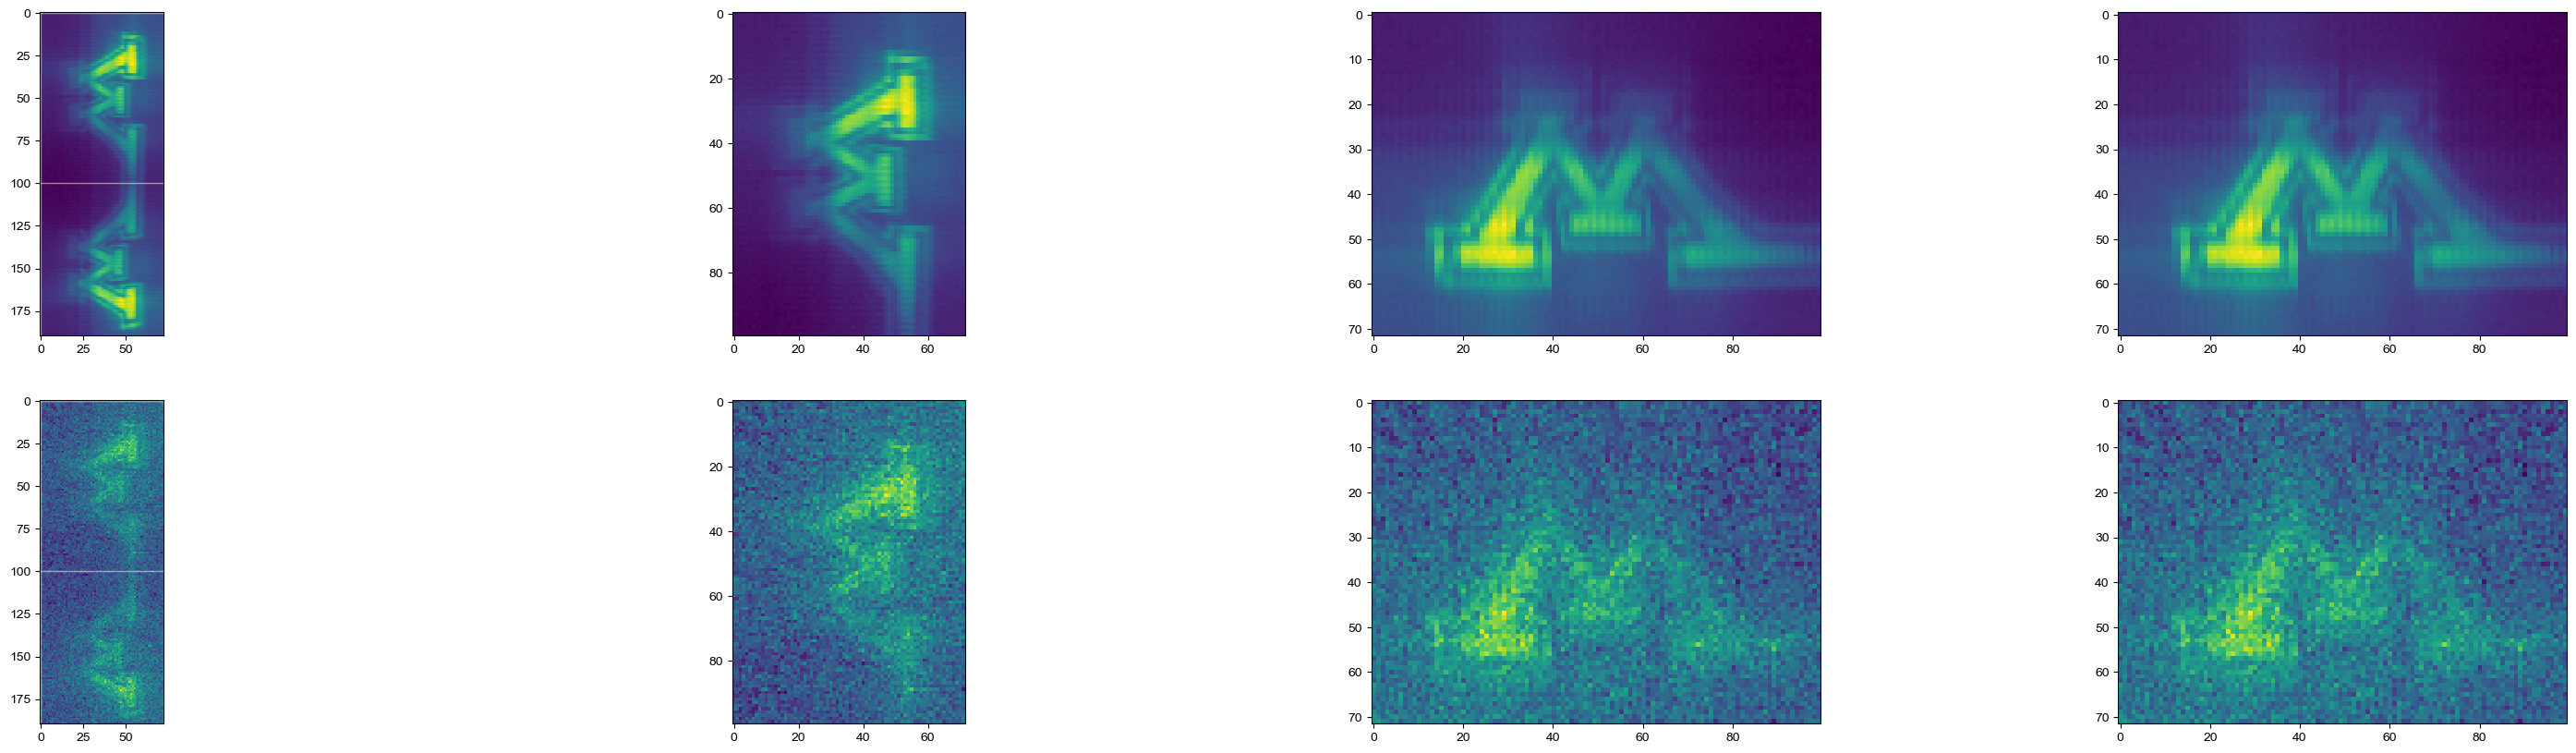

In [15]:
rotateAngle = -90

final_crop_x = [0,72]
final_crop_y = [0,100]
final_horz_scalar = 1
final_vert_scalar = 1

data_EOD_Shifted_meanProj_crop = \
    data_EOD_Shifted_meanProj[final_crop_y[0]:final_crop_y[1],final_crop_x[0]:final_crop_x[1]]
data_EOD_Shifted_meanProj_crop[np.isnan(data_EOD_Shifted_meanProj_crop)] = 0
data_EOD_Shifted_meanProj_crop_reorient = \
    np.fliplr(rotate(data_EOD_Shifted_meanProj_crop,rotateAngle,axes = (0,1)))
data_EOD_Shifted_meanProj_crop_reorient_resize = \
    cv2.resize(data_EOD_Shifted_meanProj_crop_reorient, (0,0), fx=final_horz_scalar, fy=final_vert_scalar)
data_EOD_Shifted_crop = data_EOD_Shifted[:,final_crop_y[0]:final_crop_y[1],final_crop_x[0]:final_crop_x[1]]
data_EOD_Shifted_crop[np.isnan(data_EOD_Shifted_crop)] = 0
data_EOD_Shifted_crop_reorient = \
    np.ones((data_EOD_Shifted_pad.shape[0],\
    data_EOD_Shifted_meanProj_crop_reorient.shape[0],\
    data_EOD_Shifted_meanProj_crop_reorient.shape[1]))*np.nan
data_EOD_Shifted_crop_reorient_resize = \
    np.ones((data_EOD_Shifted_pad.shape[0],\
    data_EOD_Shifted_meanProj_crop_reorient_resize.shape[0],\
    data_EOD_Shifted_meanProj_crop_reorient_resize.shape[1]))*np.nan
for t in range(data_EOD_Shifted.shape[0]):
    data_EOD_Shifted_crop_reorient[t,:,:] = \
        np.fliplr(rotate(data_EOD_Shifted_crop[t,:,:],rotateAngle,axes = (0,1)))
    data_EOD_Shifted_crop_reorient_resize[t,:,:] = \
        cv2.resize(data_EOD_Shifted_crop_reorient[t,:,:], (0,0), fx=final_horz_scalar, fy=final_vert_scalar)
t = 0
fig,ax = plt.subplots(2,4,figsize = (40,10))
im = ax[0,0].imshow(data_EOD_Shifted_meanProj,interpolation='none')
ax[0,0].axvline(final_crop_x[0],lw=1,color=(1,1,1),alpha=0.5)
ax[0,0].axvline(final_crop_x[1],lw=1,color=(1,1,1),alpha=0.5)
ax[0,0].axhline(final_crop_y[0],lw=1,color=(1,1,1),alpha=0.5)
ax[0,0].axhline(final_crop_y[1],lw=1,color=(1,1,1),alpha=0.5)
im = ax[0,1].imshow(data_EOD_Shifted_meanProj_crop,interpolation='none')
im = ax[0,2].imshow(data_EOD_Shifted_meanProj_crop_reorient,interpolation='none')
im = ax[0,3].imshow(data_EOD_Shifted_meanProj_crop_reorient_resize,interpolation='none')
im = ax[1,0].imshow(data_EOD_Shifted[t,:,:],interpolation='none')
ax[1,0].axvline(final_crop_x[0],lw=1,color=(1,1,1),alpha=0.5)
ax[1,0].axvline(final_crop_x[1],lw=1,color=(1,1,1),alpha=0.5)
ax[1,0].axhline(final_crop_y[0],lw=1,color=(1,1,1),alpha=0.5)
ax[1,0].axhline(final_crop_y[1],lw=1,color=(1,1,1),alpha=0.5)
im = ax[1,1].imshow(data_EOD_Shifted_crop[t,:,:],interpolation='none')
im = ax[1,2].imshow(data_EOD_Shifted_crop_reorient[t,:,:],interpolation='none')
im = ax[1,3].imshow(data_EOD_Shifted_crop_reorient_resize[t,:,:],interpolation='none')


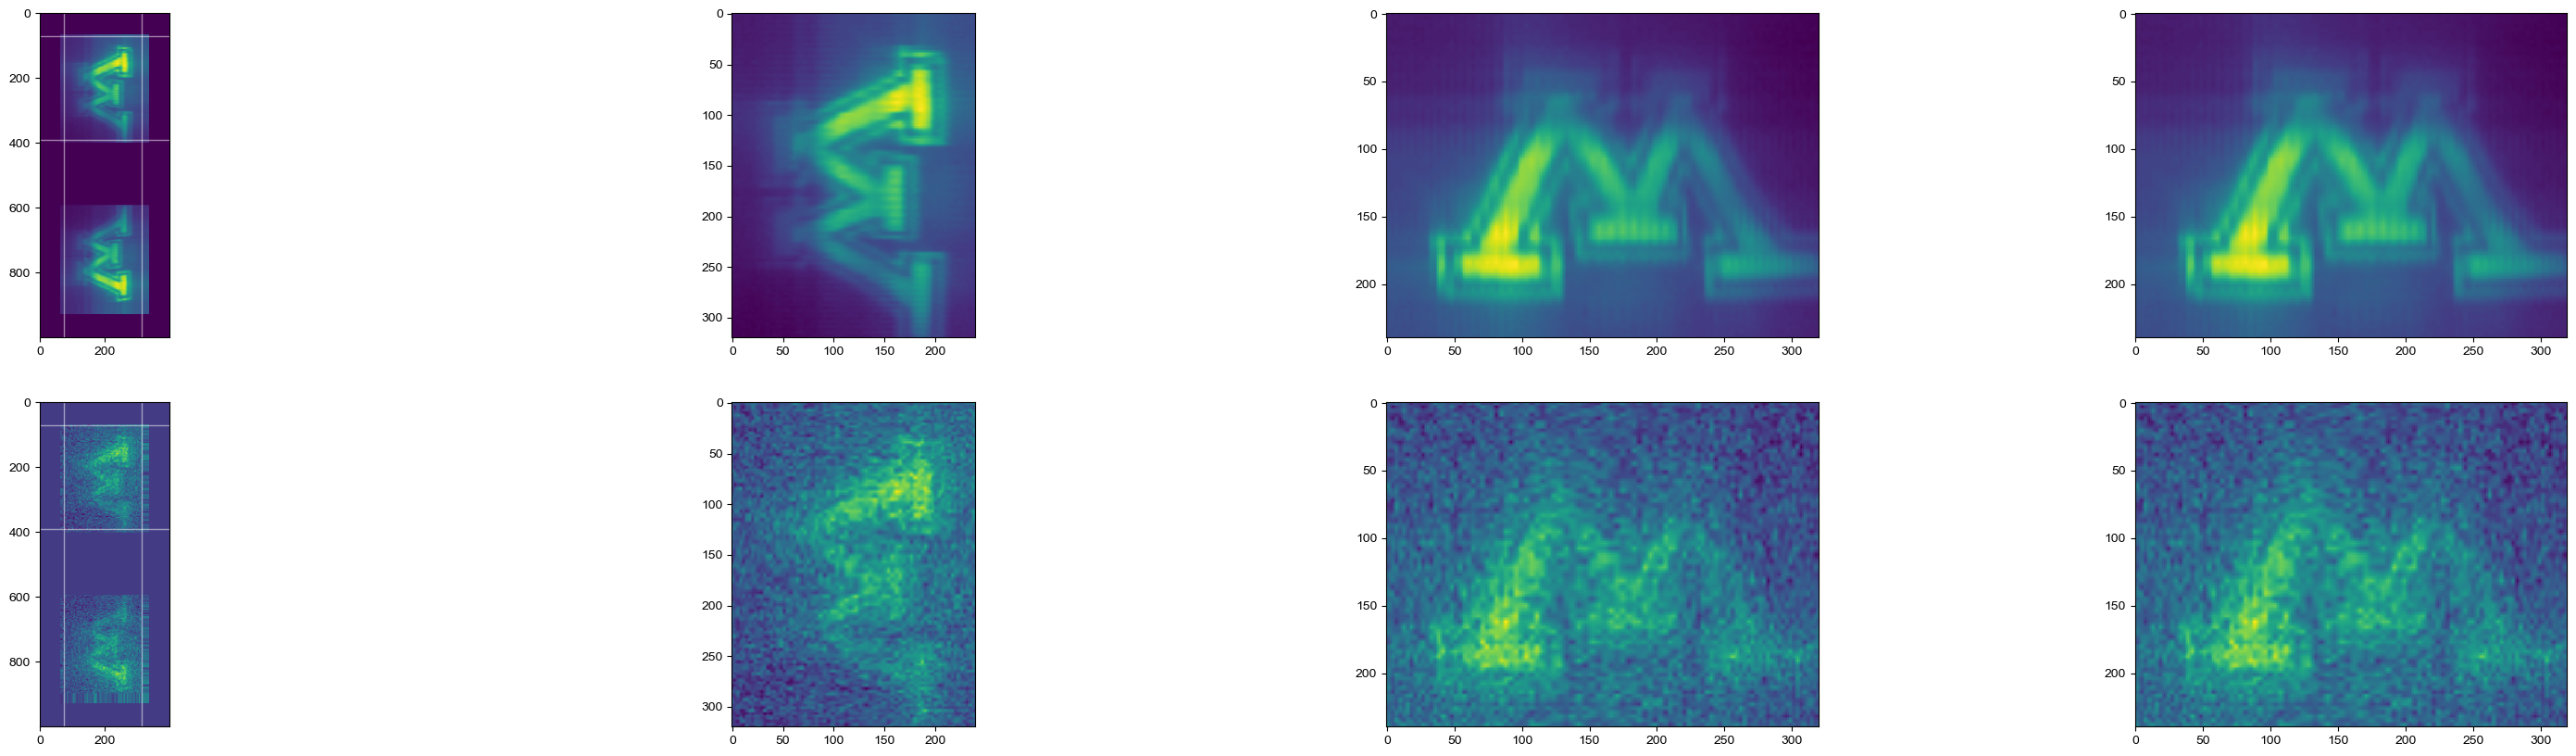

In [18]:
rotateAngle = -90

final_crop_x = [15*EOD_Upscale,63*EOD_Upscale]
final_crop_y = [14*Galvo_Upscale,78*Galvo_Upscale]
final_horz_scalar = 1
final_vert_scalar = 1

data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop = \
    data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj[final_crop_y[0]:final_crop_y[1],final_crop_x[0]:final_crop_x[1]]
data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop[np.isnan(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop)] = 0
data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop_reorient = \
    np.fliplr(rotate(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop,rotateAngle,axes = (0,1)))
data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop_reorient_resize = \
    cv2.resize(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop_reorient, (0,0), fx=final_horz_scalar, fy=final_vert_scalar)
data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop = data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr[:,final_crop_y[0]:final_crop_y[1],final_crop_x[0]:final_crop_x[1]]
data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop[np.isnan(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop)] = 0
data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient = \
    np.ones((data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr.shape[0],\
    data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop_reorient.shape[0],\
    data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop_reorient.shape[1]))*np.nan
data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient_resize = \
    np.ones((data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr.shape[0],\
    data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop_reorient_resize.shape[0],\
    data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop_reorient_resize.shape[1]))*np.nan
for t in range(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr.shape[0]):
    data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient[t,:,:] = \
        np.fliplr(rotate(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop[t,:,:],rotateAngle,axes = (0,1)))
    data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient_resize[t,:,:] = \
        cv2.resize(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient[t,:,:], (0,0), fx=final_horz_scalar, fy=final_vert_scalar)

t = 0
fig,ax = plt.subplots(2,4,figsize = (40,10))
im = ax[0,0].imshow(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj,interpolation='none')
ax[0,0].axvline(final_crop_x[0],lw=1,color=(1,1,1),alpha=0.5)
ax[0,0].axvline(final_crop_x[1],lw=1,color=(1,1,1),alpha=0.5)
ax[0,0].axhline(final_crop_y[0],lw=1,color=(1,1,1),alpha=0.5)
ax[0,0].axhline(final_crop_y[1],lw=1,color=(1,1,1),alpha=0.5)
im = ax[0,1].imshow(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop,interpolation='none')
im = ax[0,2].imshow(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop_reorient,interpolation='none')
im = ax[0,3].imshow(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_meanProj_crop_reorient_resize,interpolation='none')
im = ax[1,0].imshow(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr[t,:,:],interpolation='none')
ax[1,0].axvline(final_crop_x[0],lw=1,color=(1,1,1),alpha=0.5)
ax[1,0].axvline(final_crop_x[1],lw=1,color=(1,1,1),alpha=0.5)
ax[1,0].axhline(final_crop_y[0],lw=1,color=(1,1,1),alpha=0.5)
ax[1,0].axhline(final_crop_y[1],lw=1,color=(1,1,1),alpha=0.5)
im = ax[1,1].imshow(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop[t,:,:],interpolation='none')
im = ax[1,2].imshow(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient[t,:,:],interpolation='none')
im = ax[1,3].imshow(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient_resize[t,:,:],interpolation='none')


# <font size="5">Figure

In [19]:
figDir = '/'
figName = 'Fig5.pdf'

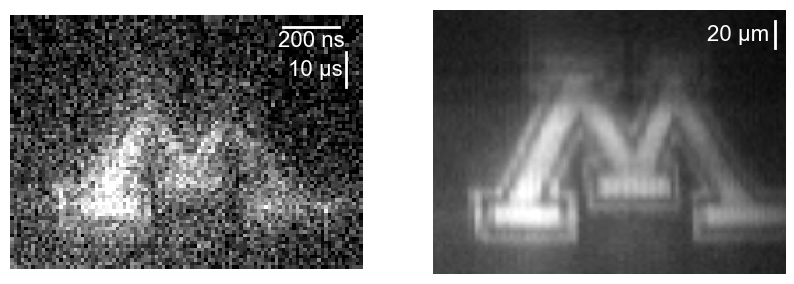

In [20]:
t = 0
y_um_px = 148.75/856.8
fontsize = 16
meanRange=list(range(0,100))
minVal = 0
maxVal = 90
fig,ax = plt.subplots(1,2,figsize = (10,10))
im = ax[0].imshow(data_EOD_Shifted_crop_reorient_resize[t,:,:],\
                    vmin = minVal,vmax = maxVal,interpolation='none',cmap = 'gray')
ax[0].plot([data_EOD_Shifted_crop_reorient_resize.shape[2]-5,data_EOD_Shifted_crop_reorient_resize.shape[2]-5],[10,20],lw=2,color=(1,1,1))
ax[0].text(data_EOD_Shifted_crop_reorient_resize.shape[2]-6,15,'10 μs',color=(1,1,1),fontsize=fontsize,ha='right',va='center')
ax[0].plot([data_EOD_Shifted_crop_reorient_resize.shape[2]-7,data_EOD_Shifted_crop_reorient_resize.shape[2]-23],[3,3],lw=2,color=(1,1,1))
ax[0].text(data_EOD_Shifted_crop_reorient_resize.shape[2]-15,4,'200 ns',color=(1,1,1),fontsize=fontsize,ha='center',va='top')
ax[0]=imshow_cleanup(ax[0])
im = ax[1].imshow(np.nanmean(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient[meanRange,:,:],axis=0),\
                    vmin = minVal,vmax = maxVal,interpolation='none',cmap = 'gray')
ax[1].plot([data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient.shape[2]-10,data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient.shape[2]-10],[10,34],lw=2,color=(1,1,1))
ax[1].text(data_EOD_Shifted_pad_Up_EODCorr_GalvoCorr_crop_reorient.shape[2]-15,22,'20 μm',color=(1,1,1),fontsize=fontsize,ha='right',va='center')
ax[1]=imshow_cleanup(ax[1])
with PdfPages(os.path.join(figDir,figName)) as pdf:
    pdf.savefig(fig,bbox_inches='tight',pad_inches=0.05,dpi=600)  # saves the current figure into a pdf page
